!!! questions "Questions"  
    - How do we prevent all variables from being incorporated 
      into a regression model?
      
!!! objectives "Objectives"  
    - To understand additional regression methods that can 
      help us improve our model fit
    - To explore PCR and PLSR as ways of dealing with variable 
      multicollinearity

## Regularised Regression. Principal components Regression. Partial Least Squares Regression.

In [1]:
# when delivering live coding, these libraries have already been loaded
import os
current_work_dir = %pwd
MLPY_ROOT = current_work_dir.split('course')[0]
NOTEBOOK_FOLDER = os.path.join(MLPY_ROOT, 'course',  'notebooks')
MODELS_FOLDER = os.path.join(NOTEBOOK_FOLDER, 'models')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import pickle
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# This is also written to generate the lesson notes; not used while live-coding
# load from previous lessons
cached_files = [
    'ames_train_y.pickle', 'ames_test_y.pickle',
    'ames_train_X.pickle', 'ames_test_X.pickle',
    'predictors.pickle', 'ames_ols_all.pickle'
]

for file in cached_files:
    with open(os.path.join(MODELS_FOLDER, file), 'rb') as f:
        objectname = file.replace('.pickle', '')
        exec(objectname + " = pickle.load(f)")
        f.close()

In [2]:
# these have not been loaded yet while teaching

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import resample


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


## A similar function has already been defined, but it's better to re copy paste here
def assess_model_fit(models,
                     model_labels, 
                     datasetX, 
                     datasetY):
    columns = ['RMSE', 'R2', 'MAE']
    rows = model_labels
    results = pd.DataFrame(0.0, columns=columns, index=rows)
    for i, method in enumerate(models):
        tmp_dataset_X = datasetX
        # while we build the model and predict on the log10Transformed 
        # sale price, we display the error in dollars as that makes more sense
        y_pred=10**(method.predict(tmp_dataset_X))
        results.iloc[i,0] = np.sqrt(mean_squared_error(10**(datasetY), y_pred))
        results.iloc[i,1] = r2_score(10**(datasetY), y_pred)
        results.iloc[i,2] = mean_absolute_error(10**(datasetY), y_pred)
    return(results.round(3))

## Hyperparameter tuning: selecting the optimal value of lambda

Recall that both ridge and lasso regression have an additional parameter, lambda, which captures the penalty for incorporating additional features in the model. 


Hence, we need to first find the optimal value of lambda (using cross-validation), and THEN fit the model, and assess its fit.

Also, for both ridge and lasso regression, the SCALE of the variables matters (because the penalty term in the objective function treats all coefficients as comparable!). So we have to use the `StandardScaler()` function to standardize all numeric variables.

We will do all of this in a scikit-learn pipeline:


### Ridge regression (L2 regularisation)

In [3]:
# logspace -  returns numbers spaced evenly on a log scale, base 2, from ^-12 to ^10
# total of 20 of them

alphas = list(np.logspace(start=-12, stop=10, num=20, base=2))
ames_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=10)),
])


ames_ridge.fit(ames_train_X, ames_train_y)
# Save for later notebooks
pickle.dump(ames_ridge, open(os.path.join(MODELS_FOLDER, 'ames_ridge.pickle'), 'wb'))

In [4]:
# what is the best value of alpha (the penalty parameter for Ridge regression?)
best_alpha_ridge = ames_ridge.named_steps.estimator.alpha_
print(best_alpha_ridge)

205.67327400112214


In [5]:
# Of the list of elements we tested, which element was it?
alphas.index(best_alpha_ridge)

17

### Lasso regression (L1 regularisation) 

In [6]:
ames_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(alphas=alphas, cv=10)),
])


ames_lasso.fit(ames_train_X, ames_train_y)
# Save model to use in later notebooks
pickle.dump(ames_lasso, open(os.path.join(MODELS_FOLDER, 'ames_lasso.pickle'), 'wb'))

In [7]:
# what is the best value of alpha (the penalty parameter for Lasso regression?)
best_alpha_lasso = ames_lasso.named_steps.estimator.alpha_
print(best_alpha_lasso)

0.0005447548426570041


In [8]:
# Of the list of elements we tested, which element was it?
alphas.index(best_alpha_lasso)

1

In [9]:
len(alphas)

20

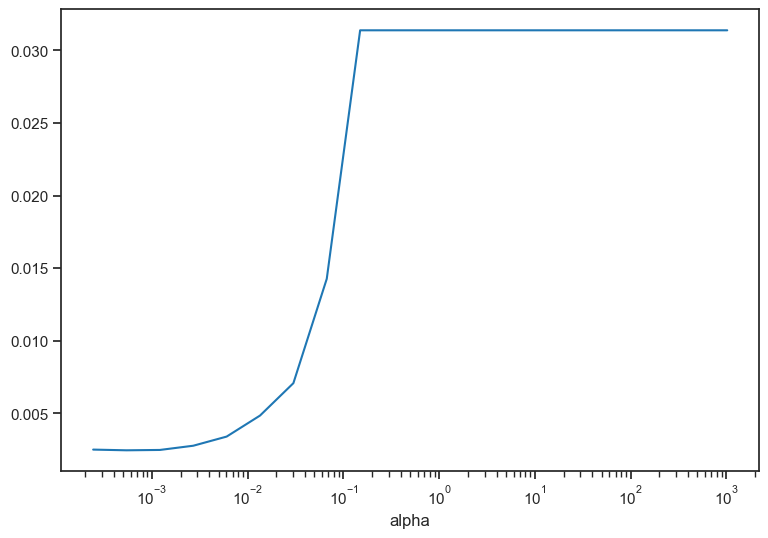

In [10]:
lasso_cv = ames_lasso.named_steps['estimator']
lasso_mse_means = lasso_cv.mse_path_.mean(axis=1)

fig, ax = plt.subplots()
ax.semilogx(lasso_cv.alphas_, lasso_mse_means, label='MSE')
ax.set_xlabel("alpha");

## Elastic net: combining L1 and L2 regularisation

Also demonstrating how to combine pipelines with parameter tuning
strategies like grid search

In [11]:
# For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty
# a * L1 + b * L2
# alpha = a + b and l1_ratio = a / (a + b)

param_grid = {"enet__alpha": alphas,
              "enet__l1_ratio": np.linspace(0.0, 1.0, num=10)}

enet_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNet()),
])
ames_enet = GridSearchCV(enet_pipeline, param_grid, scoring='r2', cv=5)

ames_enet.fit(ames_train_X, ames_train_y)
# Save model to use in later notebooks
pickle.dump(ames_enet, open(os.path.join(MODELS_FOLDER, 'ames_enet.pickle'), 'wb'))

In [12]:
# get the best parameter values 
best_params_enet = ames_enet.best_estimator_

In [13]:
# what is the best value of alpha (the penalty parameter for Lasso regression?)
print(best_params_enet["enet"].alpha)

0.002712209262919249


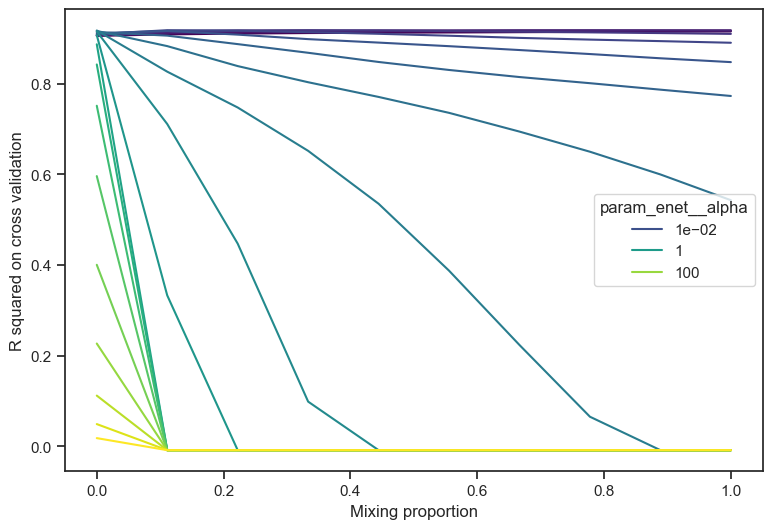

In [14]:
# Visualise the tuning performance
enet_results = pd.DataFrame.from_dict(ames_enet.cv_results_)

from matplotlib.colors import LogNorm
ax = sns.lineplot(data=enet_results, 
                  x='param_enet__l1_ratio', 
                  y='mean_test_score',
                  hue='param_enet__alpha',
                  palette=plt.cm.viridis,
                  hue_norm=LogNorm())
ax.set_xlabel("Mixing proportion")
ax.set_ylabel('R squared on cross validation');

!!! challenge "Challenge 1"

    1. Look at the coefficients for the model above. What was the balance between L1 (Lasso) and      L2 (Ridge) regression?
    2. What value of alpha was found to be optimal? Was this value expected based on the results      we got when we ran Lasso and Ridge independently?

    ??? "Solution"

        1. You can get the final L1 ratio with:

            ```python
            print(best_params_enet.l1_ratio)
            ```

        2. See [this answer](https://stackoverflow.com/questions/47365978/scikit-learn-elastic-net-approaching-ridge) for an explanation why the two values of alpha were not the same.


In [15]:
# What was the RMSE on the training data?
assess_model_fit(models = [ames_ols_all, ames_ridge, ames_lasso, ames_enet],
                 model_labels =['OLS','Ridge', 'Lasso', "ENet"], 
                 datasetX=ames_train_X,
                 datasetY=ames_train_y).sort_values("RMSE")

,RMSE,R2,MAE
OLS,15751.090,0.961,10933.508
Lasso,16480.809,0.957,11448.829
Ridge,16493.543,0.957,11463.828
ENet,16954.015,0.954,11758.565


In [16]:
# Compare with the test data!
assess_model_fit(models = [ames_ols_all, ames_ridge, ames_lasso, ames_enet],
                 model_labels =['OLS','Ridge', 'Lasso', "ENet"], 
                 datasetX=ames_test_X,
                 datasetY=ames_test_y).sort_values("RMSE")

,RMSE,R2,MAE
Lasso,19864.494,0.933,13120.146
ENet,19886.108,0.933,13273.617
Ridge,20055.583,0.931,13284.272
OLS,20602.458,0.928,13355.654


## Compare the coefficients of each of the linear models:

In [17]:
def plot_coefficients(model, labels):
    # Support both regression/regularised regression and 
    #   random forest models
    if hasattr(model, 'coef_'):
        coefs = model.coef_.ravel()
        title = 'Estimated coefficients'
    elif hasattr(model, 'feature_importances_'):
        coefs = model.feature_importances_
        title = 'Feature importances'
    table = pd.Series(coefs, index = labels)
    # Get the largest 20 values (by absolute value)
    table = table[table.abs().nlargest(20).index].sort_values()

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title(f'{title} (twenty largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

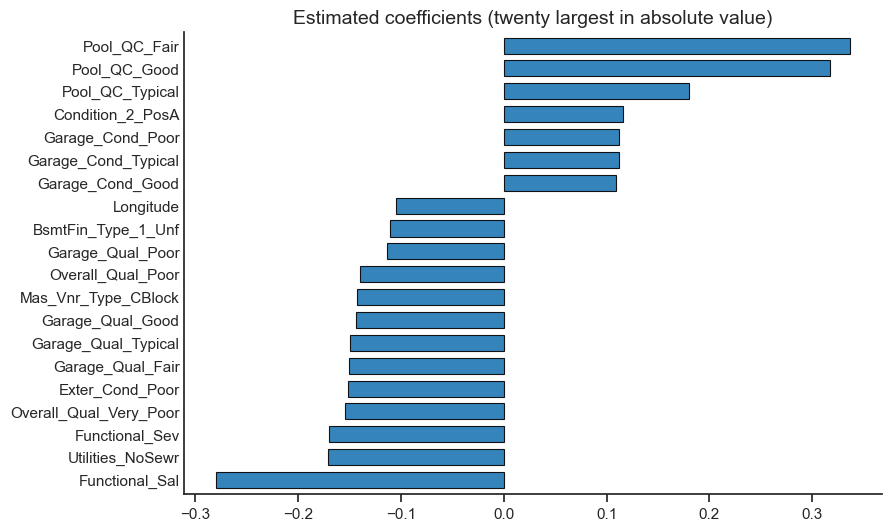

In [18]:
plot_coefficients(ames_ols_all, predictors)# the final_estimator attribute refers to the pipeline
plt.show()

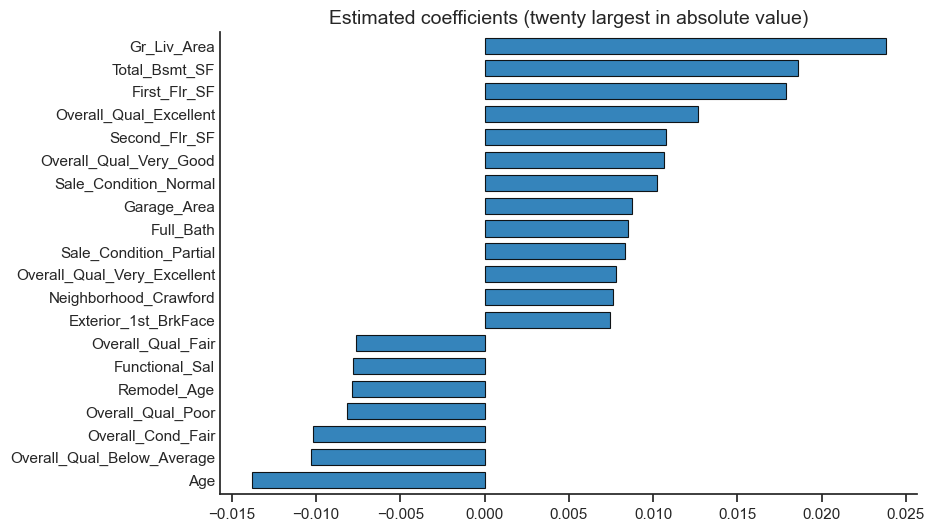

In [19]:
plot_coefficients(ames_ridge._final_estimator, predictors)# the final_estimator attribute refers to the pipeline
plt.show()

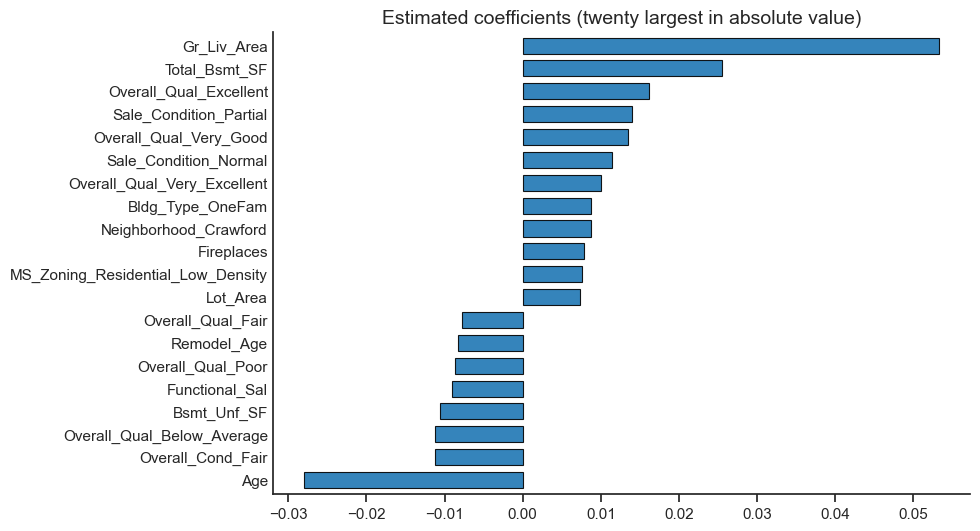

In [20]:
plot_coefficients(ames_lasso._final_estimator, predictors)# the final_estimator attribute refers to the pipeline
plt.show()

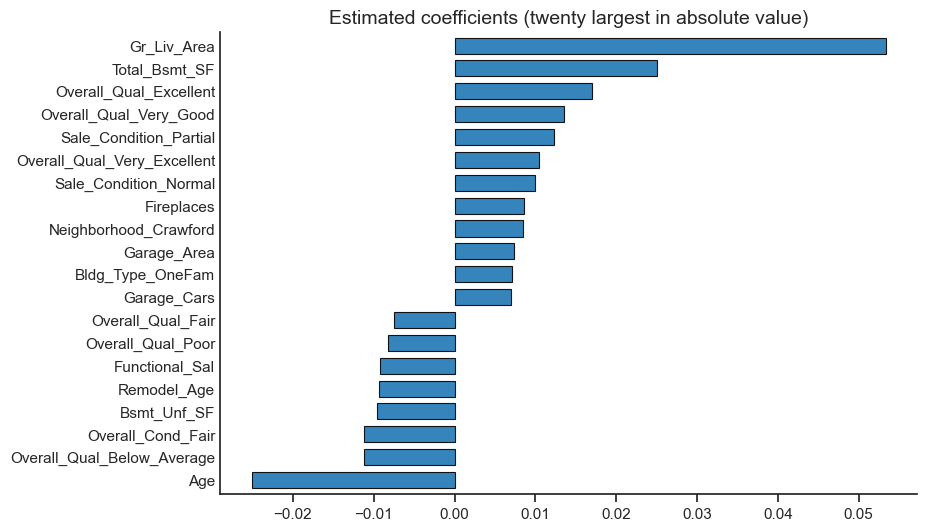

In [21]:
plot_coefficients(ames_enet.best_estimator_["enet"], predictors)
plt.show()

!!! challenge "Challenge 2"
    Compare the top coefficients for the models above. Why do you 
    think the top/bottom predictors are different for each one?

***

## Principal components regression (PCR)

In [22]:
# Define a pipeline to search for the best combination of PCA an
# and linear regression .

linreg = LinearRegression()
pca = PCA()
# how many components?
numcomp = list(np.linspace(1,len(ames_train_X.columns), num = 40).round().astype(int))

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('pca', pca), 
                       ('linreg', linreg)])
param_grid = {'pca__n_components': numcomp}
ames_pcr = GridSearchCV(pipe, param_grid, cv=5,
                      return_train_score=False)


ames_pcr.fit(ames_train_X, ames_train_y)
# Save model for later notebooks
pickle.dump(ames_pcr, open(os.path.join(MODELS_FOLDER, 'ames_pcr.pickle'), 'wb'))
    
print("Best parameter (CV score=%0.3f):" % ames_pcr.best_score_)
print(ames_pcr.best_params_)

Best parameter (CV score=0.916):
{'pca__n_components': 219}


In [23]:
# How many variables did we have?
print(ames_train_X.shape)
# Which number of PCs did we test?
print(numcomp)

(2047, 284)
[1, 8, 16, 23, 30, 37, 45, 52, 59, 66, 74, 81, 88, 95, 103, 110, 117, 124, 132, 139, 146, 153, 161, 168, 175, 182, 190, 197, 204, 211, 219, 226, 233, 240, 248, 255, 262, 269, 277, 284]


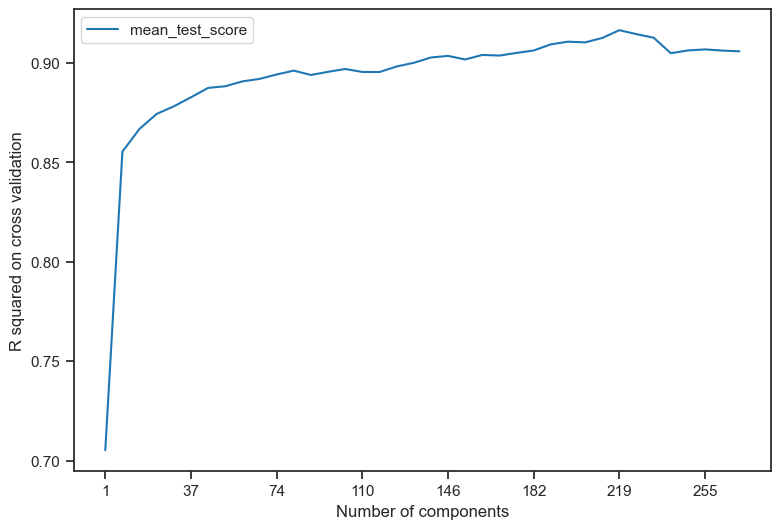

In [24]:
# Visualise the tuning performance
pcr_results = pd.DataFrame.from_dict(ames_pcr.cv_results_)

fig, ax = plt.subplots()
# R^2 is invalid for some values and needs to be filtered out
(pcr_results.query('mean_test_score > 0')
 .plot(x='param_pca__n_components', y='mean_test_score', 
       ax=ax)
)
ax.set_xlabel("Number of components")
ax.set_ylabel('R squared on cross validation');

In [25]:
# What was the RMSE on the training data?
assess_model_fit(models = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr],
                 model_labels = ['OLS','Ridge', 'Lasso', 'ENet', 'PCR'], 
                 datasetX=ames_train_X,
                 datasetY=ames_train_y).sort_values("RMSE")

,RMSE,R2,MAE
OLS,15751.090,0.961,10933.508
Lasso,16480.809,0.957,11448.829
Ridge,16493.543,0.957,11463.828
PCR,16796.219,0.955,11809.749
ENet,16954.015,0.954,11758.565


In [26]:
# What was the RMSE on the training data?
assess_model_fit(models = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr],
                 model_labels=['OLS','Ridge', 'Lasso', 'ENet', 'PCR'], 
                 datasetX=ames_test_X,
                 datasetY=ames_test_y).sort_values("RMSE")

,RMSE,R2,MAE
Lasso,19864.494,0.933,13120.146
ENet,19886.108,0.933,13273.617
Ridge,20055.583,0.931,13284.272
OLS,20602.458,0.928,13355.654
PCR,21160.008,0.924,14018.945


!!! challenge "Challenge 3"
    Look at the code above. Is there anything you can do to 
    perhaps slighly improve the fit of the PCR model?

    ??? "Solution"
        Test all of the number of principal components from 
        one below the optimum to one right above it.

***
## Partial least squares regression (PLSR)

In [27]:
# Define a pipeline to search for the best number of components in PLSR
plsr = PLSRegression()
# how many components?
numcomp = list(np.linspace(1,len(ames_train_X.columns), num = 40).round().astype(int))

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('plsr', plsr)])
param_grid = {'plsr__n_components': numcomp}
ames_plsr = GridSearchCV(pipe, param_grid, cv=5,
                      return_train_score=False)


ames_plsr.fit(ames_train_X, ames_train_y)
# Save model to use in later notebooks
pickle.dump(ames_plsr, open(os.path.join(MODELS_FOLDER, 'ames_plsr.pickle'), 'wb'))

In [28]:
# how many components were best for fitting the model?
ames_plsr.best_params_

{'plsr__n_components': 8}

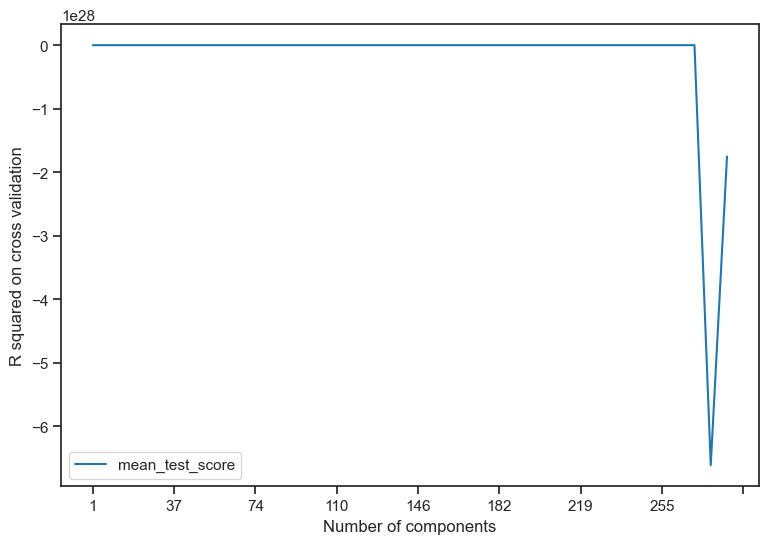

In [29]:
# Visualise the tuning performance
plsr_results = pd.DataFrame.from_dict(ames_plsr.cv_results_)

fig, ax = plt.subplots()
plsr_results.plot(
    x='param_plsr__n_components', 
    y='mean_test_score', 
    ax=ax
)
ax.set_xlabel("Number of components")
ax.set_ylabel('R squared on cross validation');

In [30]:
# What was the RMSE on the training data?
assess_model_fit(models = [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr, ames_plsr],
                 model_labels=['OLS','Ridge', 'Lasso', 'ENet', 'PCR','PLSR'], 
                 datasetX=ames_train_X,
                 datasetY=ames_train_y).sort_values("RMSE")

,RMSE,R2,MAE
OLS,15751.090,0.961,10933.508
Lasso,16480.809,0.957,11448.829
Ridge,16493.543,0.957,11463.828
PLSR,16518.167,0.957,11608.870
PCR,16796.219,0.955,11809.749
ENet,16954.015,0.954,11758.565


In [31]:
# What was the RMSE on the test data?
assess_model_fit(models= [ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr, ames_plsr],
                 model_labels=['OLS','Ridge', 'Lasso', 'ENet', 'PCR','PLSR'], 
                 datasetX=ames_test_X,
                 datasetY=ames_test_y).sort_values("RMSE")

,RMSE,R2,MAE
Lasso,19864.494,0.933,13120.146
ENet,19886.108,0.933,13273.617
Ridge,20055.583,0.931,13284.272
PLSR,20094.727,0.931,13376.642
OLS,20602.458,0.928,13355.654
PCR,21160.008,0.924,14018.945


!!! keypoints "Key points"  
    - There are many extensions to the basic regression approach 
      which can enable a better fit on the data.
    - Regularisation helps us improve the performance of regression
    - Principal components and partial least squares can help create 
      pseudo-variables which are not correlated